DSBA-6165 - Project - Stage 4<br>
Baseline Model<br><br>
Group 2:<br>
<li>Seve Jimenez<br>
<li>Bikash Khadka<br>
<li>Michael Tricanowicz

# Data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import torch

In [4]:
# Set global random state variable
random_state = 20256165

## Load the Balanced Dataset

Load the dataset from the created PyTorch file.

In [5]:
# Load the dataset
data = torch.load("balanced_dataset.pt")
print("Dataset loaded successfully!")

C:\Users\trica\AppData\Local\Temp\ipykernel_17236\3710203399.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("balanced_dataset.pt")


Dataset loaded successfully!


Confirm integrity of the data.

In [6]:
# Check number of images
print(len(data))

2147


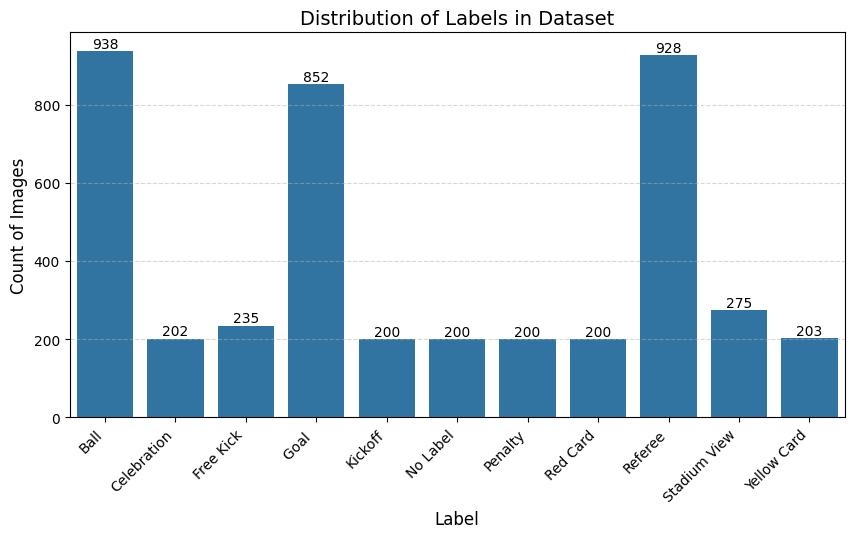

In [ ]:
# Count and Visualize Image Label Distribution in the Balanced Data Set

# Count images per label
from collections import defaultdict
label_counts = defaultdict(list)
for img_num, (labels, img) in data.items():
    if not labels:  # If labels list is empty, assign "No Label"
        label_counts["No Label"].append(img_num)
    else:
        for label in labels:
            label_counts[label].append(img_num)
label_counts = dict(sorted(label_counts.items(), key=lambda item: item[0])) # sort the dictionary alphabetically by label

# Extract label counts
count_per_label=[]
for value in label_counts.values():
    count_per_label.append(len(value))

# Plot histogram of label counts
import seaborn as sns
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=list(label_counts.keys()), y=count_per_label)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Count of Images", fontsize=12)
plt.title("Distribution of Labels in Dataset", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
# Annotate bars with counts
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',  # set the annotation to the height (value) of the bar
        (p.get_x() + p.get_width() / 2, p.get_height()),  # center annotation at the top of the bar
        ha='center',
        va='bottom'
    )
plt.show()

## Create train and test datasets

In [8]:
# Prepare to split into train and test datasets for modeling
from sklearn.model_selection import train_test_split # import necesary library
test_size = 0.20 # global test size variable

In [9]:
%%time
# Extract images and labels from dictionary into separate variables
X = np.array([data[1] for data in data.values()])  # Array of images
y = [data[0] for data in data.values()]  # list of labels

CPU times: total: 1.08 s
Wall time: 1.09 s


In [10]:
# Create indices to use to reconnect train and test sets back to the full set
X_indices = np.arange(len(X))
y_indices = np.arange(len(y))

In [11]:
%%time
# Split the indices. Perform train/test split on the X_indices then set the y indices equal to resulting split to ensure the same items are used
X_indices_train, X_indices_test, y_indices_train, y_indices_test, X_train, X_test, y_train, y_test = train_test_split(X_indices, y_indices, X, y, test_size=test_size, random_state=random_state) 

CPU times: total: 1 s
Wall time: 1.03 s


In [12]:
print("X_train shape:", X_train.shape)  # check shape of the train X array which should be (num_samples, img_dim, img_dim, 3)
print("X_test shape:", X_test.shape)  # check shape of the test X array which should be (num_samples, img_dim, img_dim, 3)
print("y_train length:", len(y_train)) # check train label length
print("y_test length:", len(y_test)) # check test label length

X_train shape: (1717, 3, 224, 224)
X_test shape: (430, 3, 224, 224)
y_train length: 1717
y_test length: 430


## Count and visualize the class distribution between train and test sets

In [47]:
from collections import Counter
# Flatten all train label lists into a single list
train_labels = [label if labels else "Not Labeled" for labels in y_train for label in (labels if labels else ["Not Labeled"])]
# Count occurrences of each label
train_counts = Counter(train_labels)
train_counts = dict(sorted(train_counts.items(), key=lambda item: item[0])) # sort the labels alphabetically so the train and test sets line up for comparison
# Flatten all test label lists into a single list
train_labels = [label if labels else "Not Labeled" for labels in y_test for label in (labels if labels else ["Not Labeled"])]
# Count occurrences of each label
test_counts = Counter(train_labels)
test_counts = dict(sorted(test_counts.items(), key=lambda item: item[0])) # sort the labels alphabetically so the train and test sets line up for comparison

In [48]:
# Combine train and test counts into a single dataframe
counts_df = pd.DataFrame({"Class": train_counts.keys(), "Train": train_counts.values(), "Test": test_counts.values()})
print(counts_df)
counts_df = counts_df.melt(id_vars="Class", var_name="Dataset", value_name="Count")

           Class  Train  Test
0           Ball    747   191
1    Celebration    165    37
2      Free Kick    183    52
3          Goal     680   172
4        Kickoff    158    42
5    Not Labeled    154    46
6        Penalty    162    38
7       Red Card    164    36
8        Referee    742   186
9   Stadium View    221    54
10   Yellow Card    162    41


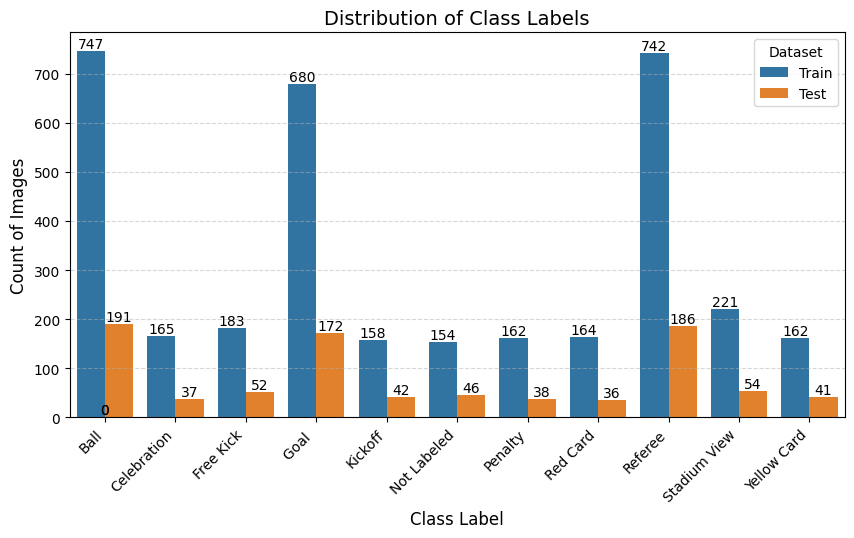

In [ ]:
# Visualize label counts
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=counts_df, x="Class", y="Count", hue="Dataset", dodge=True)
plt.xlabel("Class Label", fontsize=12)
plt.ylabel("Count of Images", fontsize=12)
plt.title("Distribution of Class Labels", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
# Annotate bars with counts
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',  # set the annotation to the height (value) of the bar
        (p.get_x() + p.get_width() / 2, p.get_height()),  # center annotation at the top of the bar
        ha='center',
        va='bottom'
    )
plt.show()

## Visualize some images to confirm successful prep

In [ ]:
# Define function to show an image where x is an image
def show_img(x, title="", bot=""):
    if isinstance(x, torch.Tensor):  # check whether the image is in tensor formate
        x = x.detach().cpu().numpy()  # if it is convert to NumPy and ensure it is moved to CPU
    if x.ndim == 3 and x.shape[0] in [1, 3]:  
        x = x.transpose(1, 2, 0)  # convert from (C, H, W) to (H, W, C) to work with imshow
    plt.imshow(x)
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    plt.xlabel(bot)
    plt.title(title, fontsize=10)
    plt.plot()

In [54]:
# Define function to show some number of images where X is an array of images, y is an array of labels, and n_images is the number of images to be displayed
import math
def display_images(X, y, index, n_images, data):
    plt.figure(figsize=(10 if n_images>=5 else 2*n_images, 2*math.ceil(n_images/5)))
    j=0
    for i in random.sample(range(len(X)), n_images):
        plt.subplot(math.ceil(n_images/5), 5 if n_images>=5 else n_images, j+1)
        show_img(X[i], title=", ".join(label.strip() for label in y[i]), bot=f"Image {list(data.keys())[index[i]]}") # Note, the image # is from the image dictionary and comes from the filename in the original dataset
        plt.plot()
        j += 1
    plt.tight_layout()

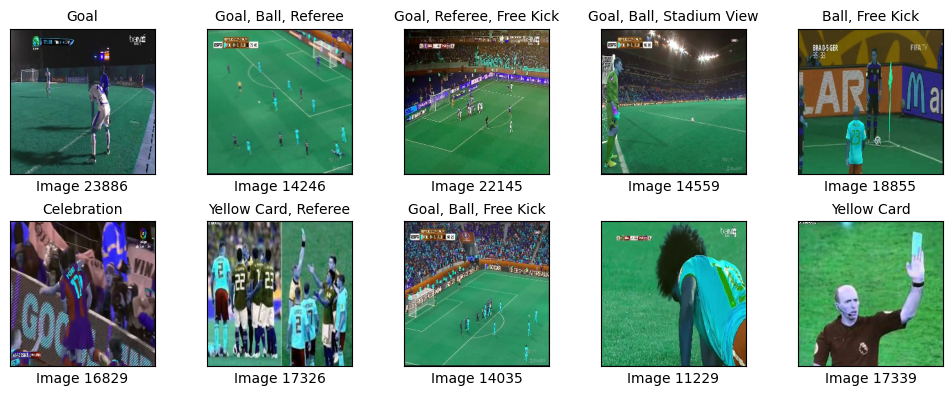

In [69]:
# Preview Train data
# Set the number images to preview
n_images_train = 10
# Show the images
display_images(X_train, y_train, X_indices_train, n_images_train, data)

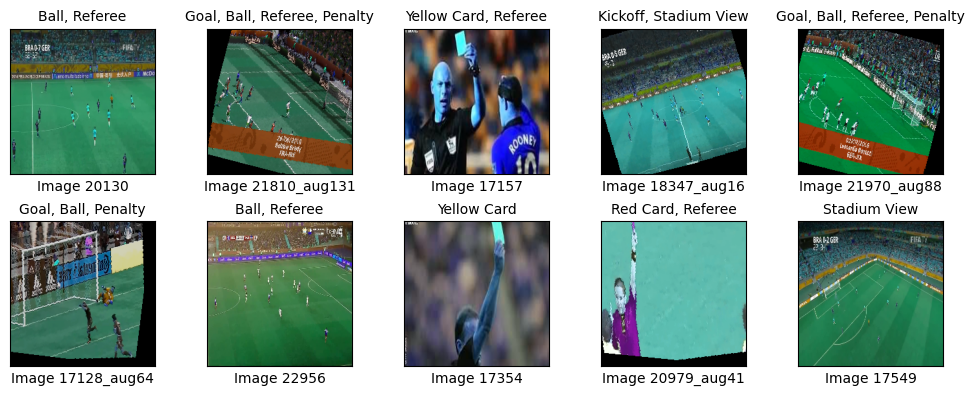

In [70]:
# Preview Test data
# Set the number images to preview
n_images_test = 10
# Show the images
display_images(X_test, y_test, X_indices_test, n_images_test, data)

# Model

In [71]:
# Import additional torch modules
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsummary import summary